In [1]:
# Import needed libraries and classes

import os

import matplotlib.pyplot as plt
from keras.src.layers import Dropout

from Code.RNN.functions.metrics import f1_score
from Code.utils.dataset import Dataset
import Code.utils.store_model as store_model
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Embedding, Input
from tensorflow.keras import models, initializers
import numpy as np
import random


from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rural\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load datasets

dataset = Dataset('../../Dataset/DatasetsGerados/dataset_training_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_training_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_output.csv',
                  '../../Dataset/dataset1_inputs.csv',
                  '../../Dataset/dataset1_outputs.csv')

X_train, y_train, X_validation, y_validation, X_test, y_test, ids = dataset.get_datasets_unprocessed('Text', 'Label', sep='\t', rem_punctuation=True)

max_words = 15000
max_len = 500

tokenizer = Tokenizer(num_words=max_words)  # limit to top max_words words
tokenizer.fit_on_texts(X_train.iloc[:, 0])

X_train = tokenizer.texts_to_sequences(X_train.iloc[:, 0])
X_validation = tokenizer.texts_to_sequences(X_validation.iloc[:, 0])
X_test = tokenizer.texts_to_sequences(X_test.iloc[:, 0])

X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_validation = preprocessing.sequence.pad_sequences(X_validation, maxlen=max_len)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

In [3]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'


seed_value = 42
random.seed(666)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

dim_embed = 100
model = Sequential()
model.add(Input((X_train.shape[1],)))
model.add(Embedding(max_words, dim_embed, embeddings_initializer=initializers.GlorotUniform(seed=44)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_validation,y_validation))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 100)       │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       800,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,302,737 (8.78 MB)

 Trainable params: 2,302,737 (8.78 MB)

 Non-trainable params: 0 (0.00 B)

AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - acc: 0.4916 - loss: 0.7086 - val_acc: 0.5000 - val_loss: 0.6865
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - acc: 0.7705 - loss: 0.4387 - val_acc: 0.9990 - val_loss: 0.0041
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - acc: 0.9918 - loss: 0.0266 - val_acc: 0.9990 - val_loss: 0.0086
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - acc: 0.9947 - loss: 0.0137 - val_acc: 0.9990 - val_loss: 0.0032
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - acc: 0.9970 - loss: 0.0072 - val_acc: 0.9990 - val_loss: 0.0019
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - acc: 0.9954 - loss: 0.0113 - val_acc: 0.9990 - val_loss: 9.5789e-04
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - acc: 0.9986 - loss: 0.0034 - val_acc: 0.9930 - val_loss: 0.0518
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - acc: 0.9975 - loss: 0.0082 - val_acc: 0.

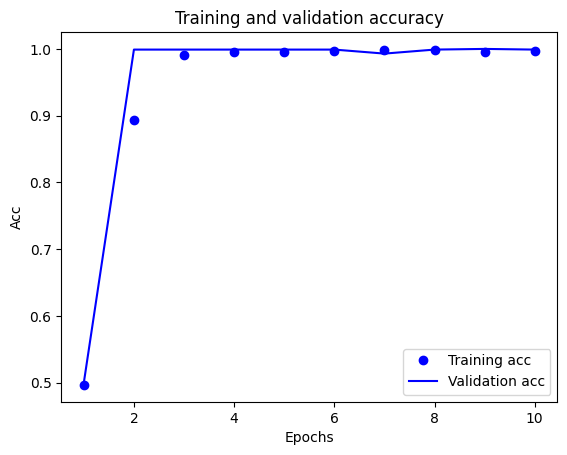

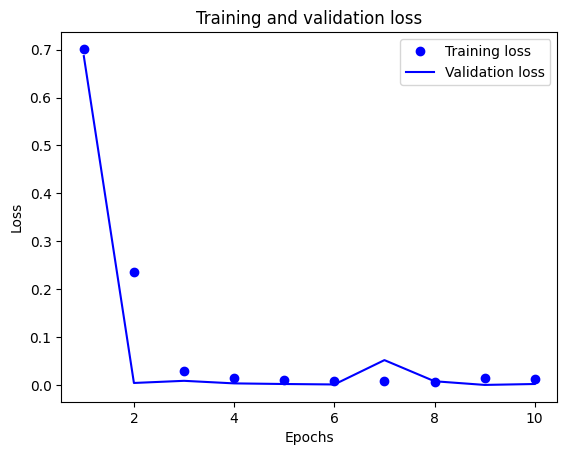

In [4]:
# Plot curves

history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Plot loss curves

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
# Predict output

output = model.predict(X_test)

if y_test is not None:
    # Evaluate Model
    print(model.evaluate(X_test, y_test))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.7484 - loss: 2.5300 
[2.367784261703491, 0.762499988079071]


In [6]:
# Store output

results_filepath = './Results/embedding_results.csv'

# Ensure the directory exists
os.makedirs(os.path.dirname(results_filepath), exist_ok=True)

results = dataset.merge_results(ids, output)
results.to_csv(results_filepath, sep='\t', index=False)

In [7]:
# Store network model

model_filepath = './Model/embedding'
model_key = 'embedding'

store_model.store_model(model_filepath, model_key, model)

In [8]:
# Retrieve network model

model_filepath = './Model/embedding'
model_key = 'embedding'

model = store_model.retrieve_model(model_filepath, model_key)

In [9]:
dataset.set_dataset_test('../../Dataset/dataset1_inputs.csv', '../../Dataset/dataset1_outputs.csv')

X_test, y_test, ids = dataset.get_test_dataset_unprocessed('Text', 'Label', sep='\t', rem_punctuation=False)

X_test = tokenizer.texts_to_sequences(X_test.iloc[:, 0])
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)